In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
import os
warnings.filterwarnings('ignore')

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data.shape

[*********************100%***********************]  1 of 1 completed


(1673, 5)

In [3]:
def create_gaf(timeseries):
    data = dict()
    gadf = GramianAngularField(method='difference', image_size=timeseries.shape[0])
    data['gadf'] = gadf.fit_transform(pd.DataFrame(timeseries).T)[0]
    return data['gadf']

In [4]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

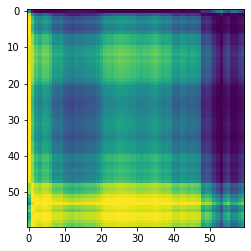

In [5]:
gadfImage = create_gaf(x_train[0]) # first image
plt.imshow(gadfImage, interpolation='nearest')
plt.show()

In [6]:
gadf_training = []

for i in x_train:
    gadf_training.append(create_gaf(i))
gadf_training = np.array(gadf_training)

gadf_training.shape

(1613, 60, 60)

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(60,60,1)),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(30000, activation='relu'),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(10000, activation='relu'),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(units=1)
])
model.summary()

Metal device set to: Apple M1


2021-11-17 02:03:45.033486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-17 02:03:45.033800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 30000)             108030000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             300010000 
_________________________________________________________________
dropout_2 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [8]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
# model.fit(gadf_training, y_train, epochs=100, batch_size=32)
model.fit(gadf_training, y_train, epochs=150, batch_size=32)

Epoch 1/150


2021-11-17 02:03:46.061111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 02:03:46.076457: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-17 02:03:46.382712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 29s 552ms/step - loss: 1789.1721
Epoch 2/150
51/51 [==============================] - 25s 480ms/step - loss: 0.8662
Epoch 3/150
51/51 [==============================] - 26s 507ms/step - loss: 0.2414
Epoch 4/150
51/51 [==============================] - 28s 547ms/step - loss: 0.1646
Epoch 5/150
51/51 [==============================] - 26s 504ms/step - loss: 0.1487
Epoch 6/150
51/51 [==============================] - 27s 530ms/step - loss: 0.1224
Epoch 7/150
51/51 [==============================] - 24s 470ms/step - loss: 0.1074
Epoch 8/150
51/51 [==============================] - 23s 458ms/step - loss: 0.1070
Epoch 9/150
51/51 [==============================] - 24s 468ms/step - loss: 0.1010
Epoch 10/150
51/51 [==============================] - 24s 461ms/step - loss: 0.1007
Epoch 11/150
51/51 [==============================] - 23s 457ms/step - loss: 0.1052
Epoch 12/150
51/51 [==============================] - 24s 462ms/step - loss: 0.0986
Epoch 13/1

51/51 [==============================] - 23s 444ms/step - loss: 0.0619
Epoch 99/150
51/51 [==============================] - 23s 458ms/step - loss: 0.0592
Epoch 100/150
51/51 [==============================] - 23s 455ms/step - loss: 0.0577
Epoch 101/150
51/51 [==============================] - 24s 465ms/step - loss: 0.0576
Epoch 102/150
51/51 [==============================] - 23s 446ms/step - loss: 0.0570
Epoch 103/150
51/51 [==============================] - 24s 474ms/step - loss: 0.0572
Epoch 104/150
51/51 [==============================] - 23s 458ms/step - loss: 0.0599
Epoch 105/150
51/51 [==============================] - 23s 445ms/step - loss: 0.0600
Epoch 106/150
51/51 [==============================] - 23s 451ms/step - loss: 0.0611
Epoch 107/150
51/51 [==============================] - 26s 514ms/step - loss: 0.0591
Epoch 108/150
51/51 [==============================] - 24s 467ms/step - loss: 0.0572
Epoch 109/150
51/51 [==============================] - 23s 451ms/step - loss: 0.

In [14]:
past_window_days = data_training.tail(window)
df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200
776,344.339996,353.649994,343.200012,347.559998,25076600


In [15]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction

x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((718, 60, 5), (718,))

In [16]:
# transfor flattened data into gaf

gadf_test = []

for i in x_test:
    gadf_test.append(create_gaf(i))
gadf_test = np.array(gadf_test)

y_pred = model.predict(gadf_test)
# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale
y_pred_final = y_pred*scale
y_test_final = y_test*scale

gadf_test.shape

(718, 60, 60)

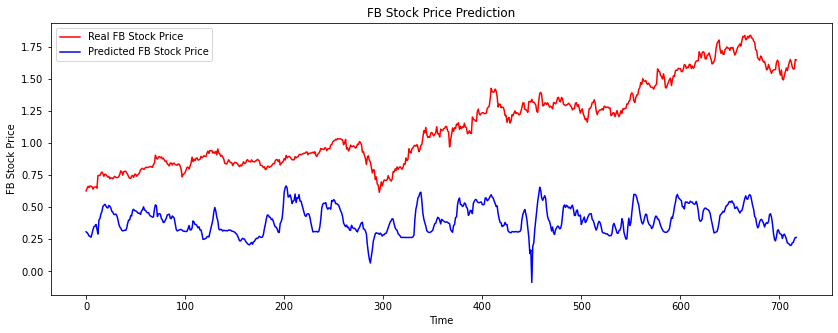

In [17]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted FB Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

# LOSS - Mean Squared Error

In [18]:
model.evaluate(gadf_test, y_test)

23/23 [==============================] - 1s 37ms/step - loss: 0.6493


0.6493444442749023